In [139]:
%matplotlib inline
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [27]:
# reading data
data = pd.read_csv('../vdjdb-dump/vdjdb_a02_4epi_trab_200.txt', sep='\t')

In [28]:
data.head()

,gene,cdr3,v.segm,j.segm,antigen.epitope
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL
1,TRA,CAASALRGMDSNYQLIW,TRAV29/DV5*01,TRAJ33*01,GILGFVFTL
2,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL
3,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL
4,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL


In [29]:
# renaming columns
data.columns = ['gene', 'CDR3b', 'TRBV', 'TRBJ', 'epitope']

In [33]:
# saving separate files for each chain
for gene in ['TRA', 'TRB']:
    data.loc[data.gene == gene][['CDR3b', 'TRBV', 'TRBJ', ]].to_csv(f'{gene}_gene.txt', sep='\t', index=False)

In [34]:
# running a script
!~/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/bin/gliph-group-discovery.pl --tcr 'TRA_gene.txt'; ~/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/bin/gliph-group-discovery.pl --tcr 'TRB_gene.txt'


GLIPH - Grouping Lymphocyte Interfaces by Paratope Hotspots
GLIPH-1.0rc

An algorithm for statistical clustering of adaptive repertoire convergence
Contact: Jacob Glanville (jakeg@stanford.edu)

  loading reference db        /home/alex/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/db/tcrab-naive-refdb-pseudovdjfasta.fa
Establishing global convergence significance cutoff
Evaluating depth of input sample in determining distance cutoff

Preparing local convergence motifs (3mers,4mers,xx.x,x.xx)
  simulated stochastic resampling of depth 766 from reference db
  loading kmers from sample...
  kmers obtained:             2982
  mindepth>=3 kmers obtained: 676
  reference db has already been loaded
Subsampling (depth 766): ##################################################
Subsampling (depth 766): ##################################################
Subsampling (depth 766): ##################################################
Subsampling (depth 766): ###############################

Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): ##################################################
Clustering (depth 766): #


GLIPH - Grouping Lymphocyte Interfaces by Paratope Hotspots
GLIPH-1.0rc

An algorithm for statistical clustering of adaptive repertoire convergence
Contact: Jacob Glanville (jakeg@stanford.edu)

  loading reference db        /home/alex/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/db/tcrab-naive-refdb-pseudovdjfasta.fa
Establishing global convergence significance cutoff
Evaluating depth of input sample in determining distance cutoff

Preparing local convergence motifs (3mers,4mers,xx.x,x.xx)
  simulated stochastic resampling of depth 799 from reference db
  loading kmers from sample...
  kmers obtained:             5302
  mindepth>=3 kmers obtained: 983
  reference db has already been loaded
Subsampling (depth 799): ##################################################
Subsampling (depth 799): ##################################################
Subsampling (depth 799): ##################################################
Subsampling (depth 799): ###############################

In [104]:
# adding clusters to data
clusters = []
data['cluster'] = None

# for each chain
for gene in ['TRA', 'TRB']:
    num_clusters = 0
    with open(f'{gene}_gene-convergence-groups.txt') as f:
        for line in f.readlines():
            cluster = line.strip().split('\t')[-1].split(' ')
            
            # if a cluster has < 10 members than pass
            if len(cluster) > 9:
                for cdr in cluster:
                    
                    # assigning a cluster
                    data.loc[(data.CDR3b == cdr) & (data.gene == gene), 'cluster'] = num_clusters
                num_clusters += 1

In [105]:
# keeping only rows that were successfully clustered
clustered_data = data.loc[~data.cluster.isna()]

In [106]:
# getting epitope weights as a share in cluster
epitope_weight = clustered_data.groupby(['gene', 'cluster', 'epitope']).epitope.count() / \
clustered_data.groupby(['gene', 'cluster']).cluster.count()

In [107]:
epitope_weight.name = 'epitope_weight'

In [111]:
# that's how it looks like
epitope_weight.to_frame().reset_index()

,gene,cluster,epitope,epitope_weight
0,TRA,0,GILGFVFTL,0.251729
1,TRA,0,LLLGIGILV,0.250346
2,TRA,0,LLWNGPMAV,0.257261
3,TRA,0,NLVPMVATV,0.240664
4,TRB,0,GILGFVFTL,0.909091
5,TRB,0,NLVPMVATV,0.090909
6,TRB,1,GILGFVFTL,0.208333
7,TRB,1,LLLGIGILV,0.708333
8,TRB,1,LLWNGPMAV,0.041667
9,TRB,1,NLVPMVATV,0.041667


In [119]:
# for each cluster getting the "predicted" epitope - the most frequent one
cluster_predicted = epitope_weight.groupby(['gene', 'cluster']).head(1)

In [127]:
# adding weights to true epitopes
clustered_data = clustered_data.merge(epitope_weight.to_frame().reset_index(), on=['gene', 'cluster', 'epitope'])

In [124]:
# renaming the column with predicted epitopes
cluster_predicted = cluster_predicted.reset_index().rename(mapper={'epitope': 'predicted_epitope'}, axis=1)

In [130]:
# adding predicted epitopes to the data
clustered_data = clustered_data.merge(cluster_predicted.drop('epitope_weight', axis=1), on=['gene', 'cluster'])

In [131]:
# creating "target" variable: if the predicted epitope is equal to the true epitope
clustered_data['target'] = clustered_data.epitope == clustered_data.predicted_epitope

In [132]:
clustered_data

,gene,CDR3b,TRBV,TRBJ,epitope,cluster,epitope_weight,predicted_epitope,target
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
1,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
2,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
3,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
4,TRA,CAMSGNAGGTSYGKLTF,TRAV12-3*01,TRAJ52*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
...,...,...,...,...,...,...,...,...,...
764,TRB,CASSYGVLGQPQHF,TRBV6-5*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
765,TRB,CSATLTGLGQPQHF,TRBV20-1*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
766,TRB,CSASQLGLGQPQHF,TRBV20-1*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
767,TRB,CASSRSGNYGYTF,TRBV5-6*01,TRBJ1-2*01,LLWNGPMAV,1,0.041667,GILGFVFTL,False


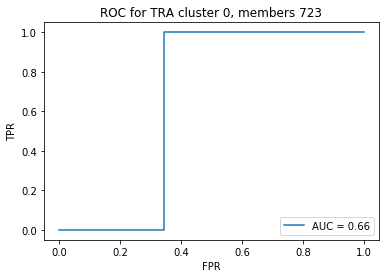

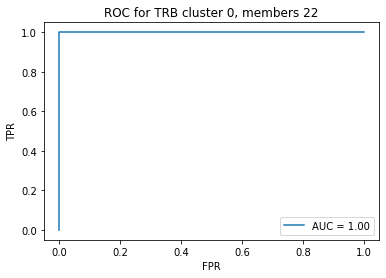

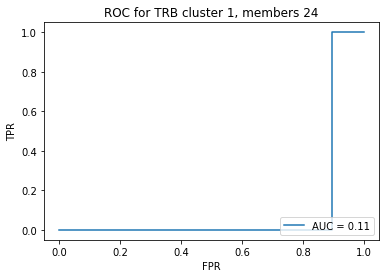

In [149]:
# plotting a ROC with AUC per cluster
for (gene, cluster), data in clustered_data.groupby(['gene', 'cluster']):
    auc = roc_auc_score(data.target, data.epitope_weight)
    fpr, tpr, _ = roc_curve(data.target, data.epitope_weight)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.title(f'ROC for {gene} cluster {cluster}, members {len(data)}')
    plt.show()